In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
import shap
from sklearn.model_selection import train_test_split
from utils.load_config_file import load_config_file

In [40]:
# ## Load Pre-Conversion MA data with Post-Conversion LTV Values
# ma_data = pd.read_csv("data/with_zcta/ma_ltv_data.csv", low_memory=False)
# ma_data.head()

In [41]:
# ma_data.shape

### SYNTHETIC DATA TESTS

In [2]:
# synth_data = pd.read_csv("s3://hc-data-science/med-adv-sales-data/synthetic_data_1M_rows.csv", low_memory= False)
# synth_data



(1000000, 153)

In [4]:
# synth_data.LTV

0          773.000000
1          325.000000
2         1052.000000
3          249.333333
4          450.916667
             ...     
999995     780.000000
999996     436.333333
999997     897.000000
999998     498.666667
999999     193.250000
Name: LTV, Length: 1000000, dtype: float64

In [4]:
# data = synth_data.copy()
# data.shape

(1000000, 152)

In [5]:
def fix_carrier_names(name):
    carrier_names_repl = {
        "O65 - United Health Care": ["O65 - AARP UnitedHealthcare Insurance Company"],
        "O65 - Anthem": [
            "O65 - Anthem Blue Cross",
            "O65 - Anthem Blue Cross and Blue Shield",
            "O65 - Anthem Blue Cross Life and Health Insurance Company",
            "O65 - Anthem and Blue Shield",
            "O65 - Anthem Life and Health Insurance Company"
        ],
        "O65 - Wellcare": ["O65 - WellCare"]
    }
    for k in carrier_names_repl:
        if name in carrier_names_repl[k]:
            carrier = k
            break
        else:
            carrier = name
    
    return carrier

data["carrier_hc"] = data["carrier_hc"].apply(lambda x: fix_carrier_names(x))

In [6]:
data.carrier_hc.unique()

array(['O65 - United Health Care', 'O65 - Centene Corporation',
       'O65 - Humana', 'O65 - Empire BlueCross BlueShield', 'O65 - Aetna',
       'O65 - Anthem', 'O65 - AmeriGroup', 'O65 - Wellcare',
       'O65 - Cigna', 'O65 - Blue Shield of California',
       'O65 - BlueCross BlueShield of Texas', 'O65 - Blue Cross of Idaho'],
      dtype=object)

In [7]:
def cal_ltv(dur, carrier):
    comms = pd.read_csv("data/carrier_commission_simplified.csv")
    # print(carrier)
    comms = comms[comms["carrier"] == carrier]
    # print(comms)
    if not np.isnan(dur) and not comms.empty:
        if dur <= 12:
            ltv = dur * (comms["year1_commission_new"].item() / 12)
        elif dur > 12:
            ltv = comms["year1_commission_new"].item() + ((dur - 12) * (comms["year2_commission"].item() / 12))  
        else:
            ltv = np.nan
    else:
        ltv = np.nan
    return ltv

data["LTV"] = data.apply(lambda x: cal_ltv(
    x['duration_in_months'],
    x['carrier_hc']
), axis=1)


In [8]:
data.to_csv("data/cms_ma_synth/cms_ma_ltv.csv", index=False)

In [9]:
data.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'contract_hc',
       'carrier_hc', 'type_hc', 'plan_hc',
       ...
       'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms', 'LTV'],
      dtype='object', length=153)

### Load synthetic data locally

In [2]:
## Load synthetic data locally
synth_data = pd.read_csv("data/cms_ma_synth/cms_ma_ltv.csv", low_memory= False)
synth_data.shape

(1000000, 153)

In [4]:
synth_temp = synth_data[:5]
synth_temp

,zcta,county,state,fips,age,gender,contract_hc,carrier_hc,type_hc,plan_hc,...,ms_adult bmi assessment,ms_care for older adults – functional status assessment,ms_appeals auto–forward,ms_appeals upheld,ms_plan all-cause readmissions,ms_controlling blood pressure,ms_beneficiary access and performance problems,ms_high risk medication,star_rating_cms,LTV
0,31405,Chatham,GA,13051,65.0,M,H6528,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice (PPO),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,773.000000
1,85716,Pima,AZ,4019,84.0,F,H0351,O65 - Centene Corporation,MAPD,Allwell CHF/Diabetes Medicare (HMO C-SNP),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,325.000000
2,60062,Cook,IL,17031,66.0,F,H2001,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice Plan 1 (PPO),...,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,1052.000000
3,24563,Pittsylvania,VA,51143,73.0,M,H8145,O65 - Humana,MA,Humana Gold Choice H8145-120 (PFFS),...,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,249.333333
4,75477,Lamar,TX,48277,82.0,F,H2001,O65 - United Health Care,MAPD,AARP Medicare Advantage Choice Plan 1 (PPO),...,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,450.916667


In [17]:
synth_temp[synth_temp.columns[5]]

0    M
1    F
2    F
3    M
4    F
Name: gender, dtype: object

In [3]:
list(synth_data.columns)

['zcta',
 'county',
 'state',
 'fips',
 'age',
 'gender',
 'contract_hc',
 'carrier_hc',
 'type_hc',
 'plan_hc',
 'enrollment_year',
 'enrollment_month',
 'duration_in_months',
 'star_rating_hc',
 'zcta_land_area_m2',
 'county_land_area_m2',
 'intersection_land_area_m2',
 'intersection_pct_county_land_area',
 'intersection_pct_zcta_land_area',
 'latitude',
 'longitude',
 'usc_land_area_m2',
 'cdc_all_teeth_lost',
 'cdc_annual_checkup',
 'cdc_arthritis',
 'cdc_binge_drinking',
 'cdc_copd',
 'cdc_cancer_except_skin',
 'cdc_cervical_cancer_screening',
 'cdc_cholesterol_screening',
 'cdc_chronic_kidney_disease',
 'cdc_colorectal_cancer_screening',
 'cdc_core_preventive_services_for_older_men',
 'cdc_core_preventive_services_for_older_women',
 'cdc_coronary_heart_disease',
 'cdc_current_asthma',
 'cdc_current_smoking',
 'cdc_dental_visit',
 'cdc_depression',
 'cdc_diabetes',
 'cdc_general_health',
 'cdc_health_insurance',
 'cdc_high_blood_pressure',
 'cdc_high_cholesterol',
 'cdc_mammograph

## Iteration 1: No Carrier info

#### Listed the unwanted features in "unwanted_features" section in Config.ini file

In [8]:
## Post-process the Dataset
from utils.post_processing_utils import process_catboost

X_train, X_test = process_catboost(data=synth_data, config_path="config/config.ini", for_training=False, save_csv= False)

In [9]:
X_train.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'star_rating_hc',
       'zcta_land_area_m2', 'county_land_area_m2', 'intersection_land_area_m2',
       ...
       'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms', 'LTV'],
      dtype='object', length=144)

In [7]:
X_train = pd.read_csv("models_py/data/train.csv", low_memory=False)
X_test = pd.read_csv("models_py/data/test.csv", low_memory=False)

# # determine categorical and numerical features
# numerical_cols = list(X_train.select_dtypes(include=["int64", "float64"]).columns)
# print("numerical_cols:", len(numerical_cols))
# categorical_cols = list(
#         X_train.select_dtypes(include=["object", "string", "bool"]).columns
# )
# print("categorical_cols:", len(categorical_cols))


In [30]:
def get_numeric_categorical(df: pd.DataFrame, target: str):
    # config = load_config_file(config_path=CONFIG_PATH)

    # determine categorical and numerical features
    numerical_cols = list(df.select_dtypes(include=["int", "float"]).columns)

    categorical_cols = list(
        df.select_dtypes(include=["object", "string", "bool"]).columns
    )

    force_categorical = ["zip"]
    for cat in force_categorical:
        feats = [col for col in df.columns if cat.lower() in col.lower()]

    for f in feats:
        if f not in categorical_cols:
            categorical_cols.append(f)
        if f in numerical_cols:
            numerical_cols.remove(f)

    predictors = list(df.columns)
    predictors.remove(target)

    return numerical_cols, categorical_cols

In [11]:
## Some preprocessing and get num and cat columns
target = "LTV"
num_cols, cat_cols = get_numeric_categorical(df=X_train, target=target)

for col in num_cols:
    X_train[col] = X_train[col].fillna(-99)
    X_test[col] = X_test[col].fillna(-99)
for col in cat_cols:
    X_train[col] = X_train[col].fillna("N/A")
    X_test[col] = X_test[col].fillna("N/A")

num_cols.remove(target)

## Split Predictors and response variables
y_train = X_train[target]
y_test = X_test[target]
X_train = X_train.drop(columns=[target])
X_test = X_test.drop(columns=[target])

# for cate in cat_cols:
#     X_train[cate] = X_train[cate].astype("category")
#     X_test[cate] = X_train[cate].astype("category")

cate: ['county', 'state', 'gender', 'usc_median_home_value', 'usc_sex_ratio', 'usc_pct_20_24', 'usc_pct_25_34', 'usc_pct_35_44', 'usc_pct_45_54', 'usc_pct_55_59', 'usc_pct_60_64', 'usc_pct_65_74', 'usc_pct_65_over', 'usc_pct_white', 'usc_pct_black', 'usc_pct_asian', 'usc_pct_hispanic_latino', 'usc_pct_american_indian_alaska_native', 'usc_pct_native_hawaiian_pacific_islander', 'cms_mapd_mrkt_leader']
num: 124


## No Carrier

In [10]:
model = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

model.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4422029	total: 3.52s	remaining: 31m 38s
1:	learn: 7.4392458	total: 6.14s	remaining: 27m 32s
2:	learn: 7.4363935	total: 8.84s	remaining: 26m 22s
3:	learn: 7.4336207	total: 11.8s	remaining: 26m 20s
4:	learn: 7.4310418	total: 14.6s	remaining: 25m 58s
5:	learn: 7.4286842	total: 17.4s	remaining: 25m 47s
6:	learn: 7.4262446	total: 20.1s	remaining: 25m 34s
7:	learn: 7.4240690	total: 22.9s	remaining: 25m 20s
8:	learn: 7.4221367	total: 25.5s	remaining: 25m 6s
9:	learn: 7.4199442	total: 28.5s	remaining: 25m 12s
10:	learn: 7.4182534	total: 31.5s	remaining: 25m 15s
11:	learn: 7.4164510	total: 34.1s	remaining: 24m 59s
12:	learn: 7.4146402	total: 36.9s	remaining: 24m 57s
13:	learn: 7.4129122	total: 39.8s	remaining: 24m 56s
14:	learn: 7.4112157	total: 42.5s	remaining: 24m 47s
15:	learn: 7.4095619	total: 45.3s	remaining: 24m 42s
16:	learn: 7.4081873	total: 47.8s	remaining: 24m 31s
17:	learn: 7.4066815	total: 50.3s	remaining: 24m 18s
18:	learn: 7.4051775	total: 53s	remaining: 24m 14s
19:	le

In [11]:
from utils.utils import calc_regression_metrics

reg_met = calc_regression_metrics(model, X_train, y_train, X_test, y_test)
reg_met

{'MAE_train': 296.92749230932696,
 'MAE_test': 298.9919165612429,
 'RMSE_train': 361.9710257901705,
 'RMSE_test': 364.19096392158366,
 'R2_score_train': 0.2367934465340421,
 'R2_score_test': 0.22601795614356435,
 'train_preds_mean_stdev': 347.87433020256157,
 'test_preds_mean_stdev': 348.1280236625611,
 'test_preds_mean': 681.2636994396788}

## Carrier

In [26]:
model_carr = catboost.CatBoostRegressor(
    iterations=540, 
    depth=12, 
    learning_rate=0.01, 
    loss_function='RMSEWithUncertainty',
    # posterior_sampling=True
)

model_carr.fit(
    X_train, 
    y_train,
    cat_features=cat_cols,
    # eval_set=(X_validation, y_validation),
    plot=True
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 7.4420021	total: 3.23s	remaining: 28m 58s
1:	learn: 7.4386326	total: 5.93s	remaining: 26m 36s
2:	learn: 7.4354209	total: 8.46s	remaining: 25m 14s
3:	learn: 7.4324020	total: 11.3s	remaining: 25m 11s
4:	learn: 7.4295624	total: 14s	remaining: 24m 58s
5:	learn: 7.4269781	total: 16.6s	remaining: 24m 35s
6:	learn: 7.4245632	total: 19.2s	remaining: 24m 18s
7:	learn: 7.4224374	total: 21.8s	remaining: 24m 11s
8:	learn: 7.4203264	total: 25s	remaining: 24m 32s
9:	learn: 7.4182588	total: 27.6s	remaining: 24m 20s
10:	learn: 7.4163472	total: 30.3s	remaining: 24m 18s
11:	learn: 7.4144741	total: 33.2s	remaining: 24m 18s
12:	learn: 7.4126751	total: 36.5s	remaining: 24m 41s
13:	learn: 7.4108639	total: 39.1s	remaining: 24m 28s
14:	learn: 7.4091382	total: 41.8s	remaining: 24m 21s
15:	learn: 7.4075231	total: 44.4s	remaining: 24m 14s
16:	learn: 7.4060077	total: 46.8s	remaining: 24m
17:	learn: 7.4045054	total: 49.6s	remaining: 23m 59s
18:	learn: 7.4029278	total: 52.6s	remaining: 24m 3s
19:	learn: 7

In [27]:
reg_met_carr = calc_regression_metrics(model_carr, X_train, y_train, X_test, y_test)
reg_met_carr

{'MAE_train': 295.5645976235855,
 'MAE_test': 297.47109945592007,
 'RMSE_train': 361.921541035324,
 'RMSE_test': 363.9372176703571,
 'R2_score_train': 0.2370021069236935,
 'R2_score_test': 0.22709610823132487,
 'train_preds_mean_stdev': 347.12129291230264,
 'test_preds_mean_stdev': 347.4390782202288,
 'test_preds_mean': 681.4697392360238}

## SHAP

#### NO CARRIER

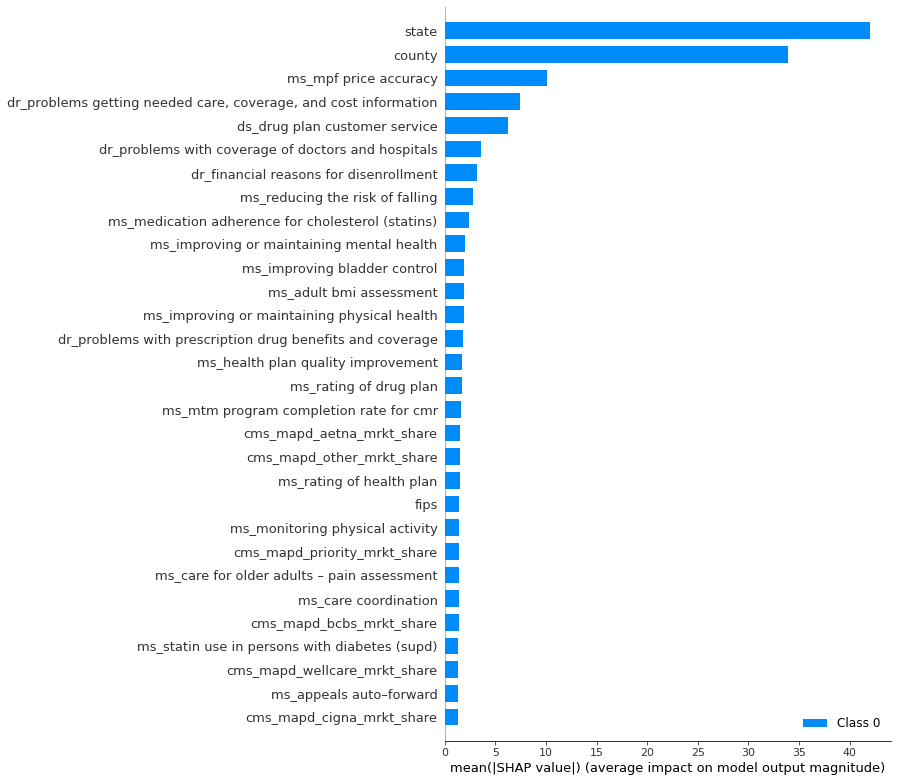

In [12]:
# ts = X_test.drop(columns="LTV")
# ts_lab = X_test["LTV"]

## SHAP
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data without Carrier info. Test dataset: 200k x 143")
plt.savefig(f"data/cms_ma_synth/test_synth_catboost.png", dpi=200, bbox_inches="tight")

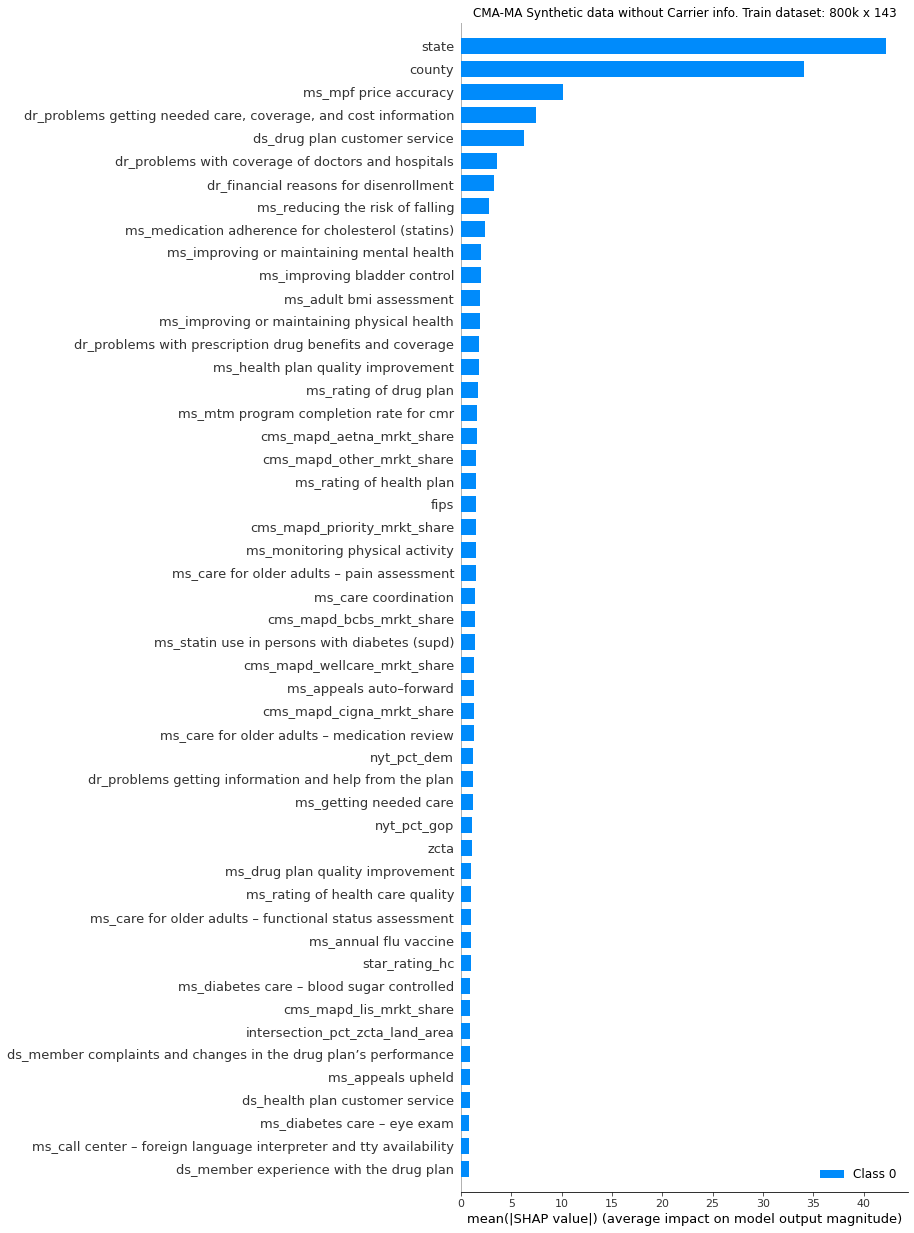

In [20]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data without Carrier info. Train dataset: 800k x 143")
plt.savefig(f"data/cms_ma_synth/train_synth_catboost.png", dpi=200, bbox_inches="tight")

In [68]:
X_train.columns

Index(['zcta', 'county', 'state', 'fips', 'age', 'gender', 'carrier_hc',
       'star_rating_hc', 'zcta_land_area_m2', 'county_land_area_m2',
       ...
       'ms_improving or maintaining mental health', 'ms_adult bmi assessment',
       'ms_care for older adults – functional status assessment',
       'ms_appeals auto–forward', 'ms_appeals upheld',
       'ms_plan all-cause readmissions', 'ms_controlling blood pressure',
       'ms_beneficiary access and performance problems',
       'ms_high risk medication', 'star_rating_cms'],
      dtype='object', length=144)

### Carrier

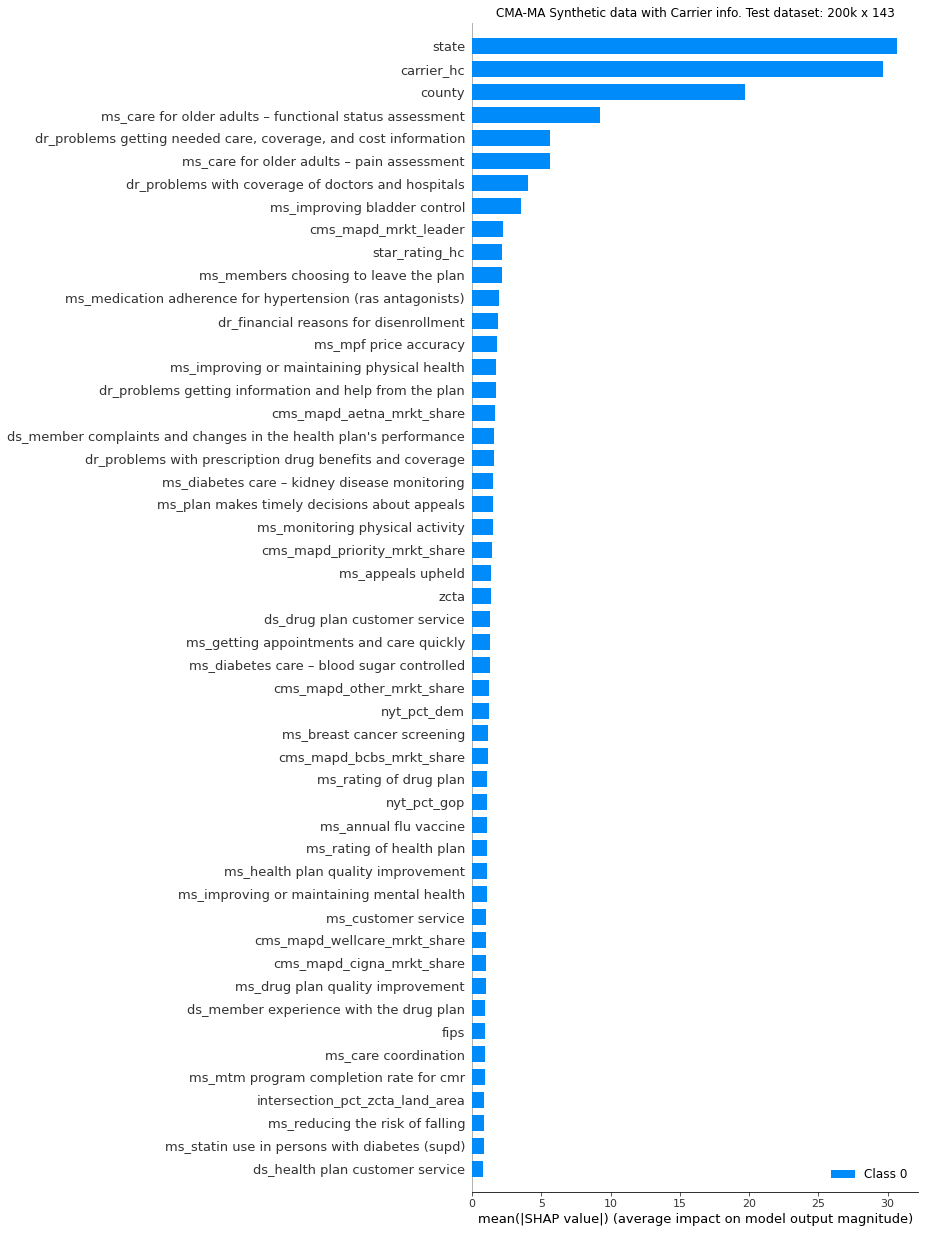

In [28]:
explainer = shap.TreeExplainer(model_carr)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X_test.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data with Carrier info. Test dataset: 200k x 143")
plt.savefig(f"data/cms_ma_synth/test_synth_carr_catboost.png", dpi=200, bbox_inches="tight")

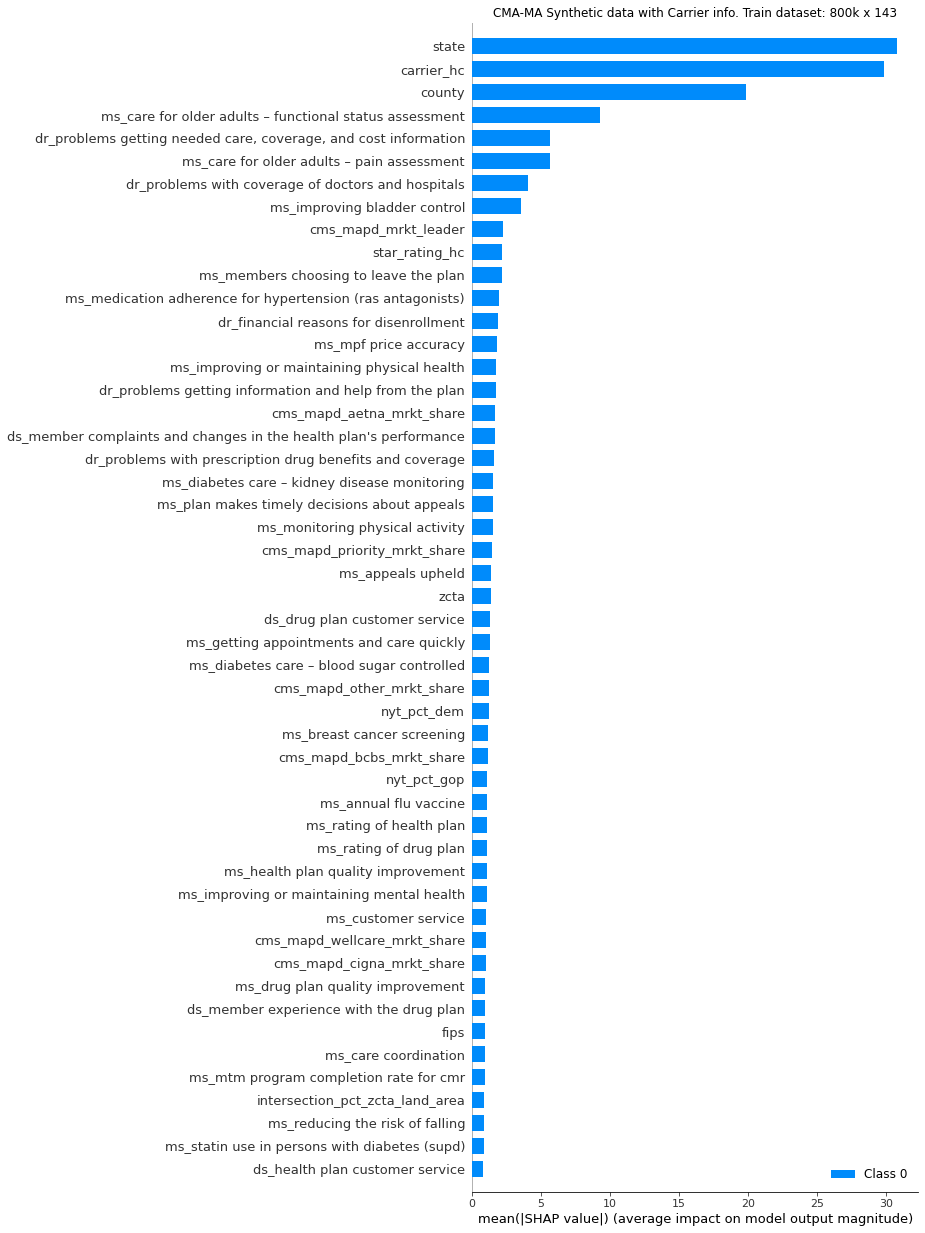

In [29]:
shap_values = explainer.shap_values(X_train)

shap.summary_plot(
    shap_values,
    features=X_train,
    feature_names=X_train.columns,
    max_display=50,
    plot_type="bar",
    # matplotlib=True,
    show=False,
)
plt.title("CMA-MA Synthetic data with Carrier info. Train dataset: 800k x 143")
plt.savefig(f"data/cms_ma_synth/train_synth_carr_catboost.png", dpi=200, bbox_inches="tight")